# SML Assignment: MNIST Classification using MLE, PCA, FDA, and Discriminant Analysis

## Introduction
In this assignment, we will classify handwritten digits from the MNIST dataset using:
- **Maximum Likelihood Estimation (MLE)**
- **Principal Component Analysis (PCA)**
- **Fisher’s Discriminant Analysis (FDA)**
- **Linear Discriminant Analysis (LDA)** and **Quadratic Discriminant Analysis (QDA)**

#### We will start with importing some important library as we cannot use many libaries so i have tried to do most work through numpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

#### This is a standard loading function 

In [4]:
# Load dataset standard function
def load_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)
        images = np.frombuffer(f.read(), dtype=np.uint8)
        return images.reshape(-1, 784).astype(np.float32)

def load_label(filename):
    with open(filename, 'rb') as f:
        f.read(8)
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

#### The dataset was downloaded from [Kaggle]((https://www.kaggle.com/datasets/hojjatk/mnist-dataset),)

In [5]:
#now we load the data 
X_train_t = load_images("dataset/train-images-idx3-ubyte")
X_test_t = load_images("dataset/t10k-images-idx3-ubyte")
y_train_t = load_label("dataset/train-labels-idx1-ubyte")
y_test_t = load_label("dataset/t10k-labels-idx1-ubyte")


1. **Data Preprocessing**
   - Load the MNIST dataset.
   - Filter classes 0, 1, and 2.
   - Normalize the data.

In [43]:
#function to filder and normalize the data [0, 1]
def filter_data_and_normalize(images, labels):

    mask = np.isin(labels, [0, 1, 2])
    images = images[mask]
    labels = labels[mask]

    img = []
    lab = []
    for c in [0, 1, 2]:
        ind = np.random.choice(np.where(labels==c)[0], 100, replace=False)
        img.append(images[ind])
        lab.append(labels[ind])

    img = np.vstack(img) #for vertical stacking
    img = img.T
    lab = np.hstack(lab) #hor stacking

    img /= 255.0    #normalize
    return img, lab

In [18]:
#this si the required data we will use this globally
X_train, y_train = filter_data_and_normalize(X_train_t, y_train_t)
X_test, y_test = filter_data_and_normalize(X_test_t, y_test_t)
X_train.shape

(784, 300)

2. **MLE Estimation**
   - Compute the mean and covariance matrix for each class.

In [8]:
def compute_mle(data, labels):
    means = {}
    cov_c = {}
    for c in [0, 1, 2]:
        # Select data for class c
        class_data = data[:, labels == c]
        N = class_data.shape[1]
        
        # Calculate mean
        # mu = np.mean(class_data, axis=1, keepdims=True)
        mu = np.sum(class_data, axis=1, keepdims=True)/N

        # Calculate covariance matrix
        centered_data = class_data - mu
        cov = np.dot(centered_data, centered_data.T) / (N - 1)
        
        means[c] = mu
        cov_c[c] = cov

    return means, cov_c

In [ ]:
#same for this 
means_c, cov_c = compute_mle(X_train, y_train)
global_mean = np.mean(X_train, axis=1, keepdims=True)  # Global mean for FDA
#cov is 3 x 784 x 784

3

3. **Dimensionality Reduction using PCA**
   - Retain 95% of the variance.

In [10]:
# PCA Implementation
def find_pca(X, threshold = 0.95):
    N = X.shape[1]
    global_mean = np.mean(X, axis=1, keepdims=True)
    X_c = X - global_mean
    S = np.dot(X_c, X_c.T) / (N - 1)

    # Eigenvalue and eigenvector decomposition
    eigval, eigvec = np.linalg.eigh(S)

    # Sort eigenvalues and eigenvectors in descending order
    ind = np.argsort(eigval)[::-1]
    eigval, eigvec = eigval[ind], eigvec[:, ind]

    # Calculate cumulative variance and determine number of components
    cum_var = np.cumsum(eigval) / np.sum(eigval)
    p = np.searchsorted(cum_var, threshold) + 1
    U_p = eigvec[:, :p]

    return U_p

In [ ]:
Up = find_pca(X_train)
Up.shape #expected 784, x

(784, 82)

In [19]:
# Projection onto PCA space
X_c = X_train - np.mean(X_train, axis=1, keepdims=True)
Y = np.dot(Up.T, X_c)
Y.shape

(82, 300)

4. **Fisher’s Discriminant Analysis (FDA)**
   - Compute the optimal projection for class separation.

In [20]:
# FDA Implementation
def find_fda(X, means, data, global_mean):
    Nc = [X.shape[1] for X in data]
    N = len(data)

    # Between-class scatter matrix (SB)
    Sb = np.zeros((X.shape[0], X.shape[0]))
    for c in range(N):
        dm = means[c] - global_mean
        Sb += Nc[c] * np.dot(dm, dm.T)

    # Within-class scatter matrix (SW)
    Sw = np.zeros((X.shape[0], X.shape[0]))
    for c in range(N):
        Xc = data[c]
        Xcc = Xc - means[c]
        Sw += np.dot(Xcc, Xcc.T)

    # Use pseudo-inverse for stability
    Sw_pseudoinv = np.linalg.pinv(Sw)

    # Eigenvalue decomposition
    eigval, eigvec = eigh(np.dot(Sw_pseudoinv, Sb))

    # Sort eigenvectors by eigenvalues in descending order
    ind = np.argsort(eigval)[::-1]

    return eigvec[:, ind][:, :N-1]

In [21]:
Wfda = find_fda(X_train, means_c, [X_train[:,:100], X_train[:,100:200], X_train[:,200:300]], global_mean)
Wfda.shape

(784, 2)

5. **Classification using LDA and QDA**
   - Evaluate the performance of LDA and QDA.

In [23]:
#lda
def train_lda(X_train, labels, reg_param=1e-5):
    classes = np.unique(labels)
    d, N = X_train.shape
    means = {}
    cov = np.zeros((d, d))  # Shared covariance matrix
    priors = {}

    # Compute means and covariance
    for c in classes:
        X_c = X_train[:, labels == c]  
        N_c = X_c.shape[1] 
        means[c] = np.mean(X_c, axis=1, keepdims=True)  
        
        X_centered = X_c - means[c] 
        cov += (X_centered @ X_centered.T) / (N_c - 1)  # Add to shared covariance matrix
        
        priors[c] = N_c / N  # P(c) = Nc / N
    
    # Compute the overall covariance matrix
    cov /= len(classes)  # Average over classes
    
    # Regularize the covariance matrix to ensure it's invertible as told by sir
    cov += reg_param * np.eye(d)  # Add small value to diagonal
    
    return means, cov, priors, classes

In [24]:
def predict_lda(X_test, means, cov, priors, classes):
    d, N = X_test.shape  # d = features, N = samples
    predictions = np.zeros(N, dtype=int)  # Store predicted class labels

    # Compute the inverse of the covariance matrix once
    cov_inv = np.linalg.inv(cov)

    for j in range(N):
        x = X_test[:, j:j+1]  # (d, 1) column vector
        scores = {}

        for c in classes:
            mean_c = means[c]  # (d, 1)
            delta = x - mean_c  # (d, 1)

            # Compute LDA discriminant function
            score = -0.5 * delta.T @ cov_inv @ delta + np.log(priors[c])  # Linear discriminant function
            scores[c] = score

        # Choose the class with the highest score
        predictions[j] = max(scores, key=scores.get)

    return predictions


In [28]:
# QDA Implementation
def train_qda(X_train, labels):
    classes = np.unique(labels)
    d, N = X_train.shape
    means = {}
    covariances = {}
    priors = {}

    for c in classes:
        X_c = X_train[:, labels == c]
        N_c = X_c.shape[1]  # Number of samples in class c
        means[c] = np.mean(X_c, axis=1, keepdims=True)  # (784, 1)
        
        # Manually calculate the covariance matrix
        X_centered = X_c - means[c]  # Center the data
        covariances[c] = (X_centered @ X_centered.T) / (N_c - 1)  # (784, 784)
        
        priors[c] = N_c / N  # P(c) = Nc / N

    return means, covariances, priors, classes

In [29]:
def predict_qda(X_test, means, covariances, priors, classes):
    d, N = X_test.shape  # d = 784, N = samples
    predictions = np.zeros(N, dtype=int)  # Store predicted class labels

    cov_invs = {}
    logdets = {}    #log(det(cov))

    for c in classes:
        cov_c = covariances[c] + 1e-5 * np.eye(d)  # Regularization to avoid singularity
        cov_invs[c] = np.linalg.inv(cov_c)  # Precompute inverse
        _, logdets[c] = np.linalg.slogdet(cov_c)  # Numerically stable log determinant

    for j in range(N):
        x = X_test[:, j:j+1]  # (784, 1) column vector
        scores = {}

        for c in classes:
            mean_c = means[c]  # (784, 1)
            delta = x - mean_c  # (784, 1)

            # Compute QDA discriminant function
            scores[c] = -0.5 * delta.T @ cov_invs[c] @ delta - 0.5 * logdets[c] + np.log(priors[c])

        # Choose the class with the highest score
        predictions[j] = max(scores, key=scores.get)

    return predictions

In [30]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [32]:
# Train QDA and Predict
qdamean, qdavar, qdaprior, qdaclass = train_qda(X_train, y_train)
qda_pred_y = predict_qda(X_train, qdamean, qdavar, qdaprior, qdaclass)
qda_pred_y_test = predict_qda(X_test, qdamean, qdavar, qdaprior, qdaclass)

qda_ac_t = accuracy(y_train, qda_pred_y)
qda_ac_te = accuracy(y_test, qda_pred_y_test)
print(f"QDA Train Accuracy: {qda_ac_t:.4f}")
print(f"QDA Test Accuracy: {qda_ac_te:.4f}")


QDA Train Accuracy: 1.0000
QDA Test Accuracy: 0.9833


In [33]:
# Train LDA and Predict with regularization
lda_means, lda_cov, lda_priors, lda_classes = train_lda(X_train, y_train)
lda_pred_y = predict_lda(X_train, lda_means, lda_cov, lda_priors, lda_classes)
lda_pred_y_test = predict_lda(X_test, lda_means, lda_cov, lda_priors, lda_classes)

lda_ac_t = accuracy(y_train, lda_pred_y)
lda_ac_te = accuracy(y_test, lda_pred_y_test)

print(f"LDA Train Accuracy: {lda_ac_t:.4f}")
print(f"LDA Test Accuracy: {lda_ac_te:.4f}")

LDA Train Accuracy: 1.0000
LDA Test Accuracy: 0.8700


In [34]:
X_train_fda = np.dot(Wfda.T, X_train)
X_test_fda = np.dot(Wfda.T, X_test)

# Train and evaluate LDA on FDA-transformed data
lda_means_fda, lda_cov_fda, lda_priors_fda, lda_classes_fda = train_lda(X_train_fda, y_train)
lda_pred_y_fda = predict_lda(X_train_fda, lda_means_fda, lda_cov_fda, lda_priors_fda, lda_classes_fda)
lda_pred_y_test_fda = predict_lda(X_test_fda, lda_means_fda, lda_cov_fda, lda_priors_fda, lda_classes_fda)

lda_ac_t_fda = accuracy(y_train, lda_pred_y_fda)
lda_ac_te_fda = accuracy(y_test, lda_pred_y_test_fda)

print("Accuracy after FDA")
print(f"LDA Train : {lda_ac_t_fda:.4f}")
print(f"LDA Test : {lda_ac_te_fda:.4f}\n")

Accuracy after FDA
LDA Train : 0.9367
LDA Test : 0.9133



In [36]:
# Train and evaluate QDA on FDA-transformed data
qda_means_fda, qda_cov_fda, qda_priors_fda, qda_classes_fda = train_qda(X_train_fda, y_train)
qda_pred_y_fda = predict_qda(X_train_fda, qda_means_fda, qda_cov_fda, qda_priors_fda, qda_classes_fda)
qda_pred_y_test_fda = predict_qda(X_test_fda, qda_means_fda, qda_cov_fda, qda_priors_fda, qda_classes_fda)

qda_ac_t_fda = accuracy(y_train, qda_pred_y_fda)
qda_ac_te_fda = accuracy(y_test, qda_pred_y_test_fda)

print("Accuracy after FDA")
print(f"QDA Train : {qda_ac_t_fda:.4f}")
print(f"QDA Test : {qda_ac_te_fda:.4f}")

Accuracy after FDA
QDA Train : 0.9433
QDA Test : 0.9200


In [37]:
Up_95 = find_pca(X_train, threshold=0.95)

X_train_pca = np.dot(Up_95.T, X_train)
X_test_pca = np.dot(Up_95.T, X_test)

lda_means_pca, lda_cov_pca, lda_priors_pca, lda_classes_pca = train_lda(X_train_pca, y_train)
lda_pred_y_pca = predict_lda(X_train_pca, lda_means_pca, lda_cov_pca, lda_priors_pca, lda_classes_pca)
lda_pred_y_test_pca = predict_lda(X_test_pca, lda_means_pca, lda_cov_pca, lda_priors_pca, lda_classes_pca)

lda_ac_t_pca = accuracy(y_train, lda_pred_y_pca)
lda_ac_te_pca = accuracy(y_test, lda_pred_y_test_pca)

print("Accuracy after PCA (95% variance)")
print(f"LDA Train: {lda_ac_t_pca:.4f}")
print(f"LDA Test: {lda_ac_te_pca:.4f}")
print(f"Number of components retained : {Up_95.shape[1]}")

Accuracy after PCA (95% variance)
LDA Train: 0.9867
LDA Test: 0.9733
Number of components retained : 82


In [38]:
# PCA with 90% variance
Up_90 = find_pca(X_train, threshold=0.90)

X_train_pca_90 = np.dot(Up_90.T, X_train)
X_test_pca_90 = np.dot(Up_90.T, X_test)

lda_means_pca_90, lda_cov_pca_90, lda_priors_pca_90, lda_classes_pca_90 = train_lda(X_train_pca_90, y_train)
lda_pred_y_pca_90 = predict_lda(X_train_pca_90, lda_means_pca_90, lda_cov_pca_90, lda_priors_pca_90, lda_classes_pca_90)
lda_pred_y_test_pca_90 = predict_lda(X_test_pca_90, lda_means_pca_90, lda_cov_pca_90, lda_priors_pca_90, lda_classes_pca_90)

lda_ac_t_pca_90 = accuracy(y_train, lda_pred_y_pca_90)
lda_ac_te_pca_90 = accuracy(y_test, lda_pred_y_test_pca_90)

print("Accuracy after PCA (90% variance)")
print(f"LDA Train : {lda_ac_t_pca_90:.4f}")
print(f"LDA Test : {lda_ac_te_pca_90:.4f}")
print(f"Number of components retained : {Up_90.shape[1]}")

Accuracy after PCA (90% variance)
LDA Train : 0.9833
LDA Test : 0.9600
Number of components retained : 50


In [39]:
# Use only the first two principal components
Up_2 = Up_95[:, :2]

X_train_pca_2 = np.dot(Up_2.T, X_train)
X_test_pca_2 = np.dot(Up_2.T, X_test)

lda_means_pca_2, lda_cov_pca_2, lda_priors_pca_2, lda_classes_pca_2 = train_lda(X_train_pca_2, y_train)
lda_pred_y_pca_2 = predict_lda(X_train_pca_2, lda_means_pca_2, lda_cov_pca_2, lda_priors_pca_2, lda_classes_pca_2)
lda_pred_y_test_pca_2 = predict_lda(X_test_pca_2, lda_means_pca_2, lda_cov_pca_2, lda_priors_pca_2, lda_classes_pca_2)

lda_ac_t_pca_2 = accuracy(y_train, lda_pred_y_pca_2)
lda_ac_te_pca_2 = accuracy(y_test, lda_pred_y_test_pca_2)

print("Accuracy after using first 2 PCs")
print(f"LDA Train : {lda_ac_t_pca_2:.4f}")
print(f"LDA Test : {lda_ac_te_pca_2:.4f}")
print(f"Number of components retained: {Up_2.shape[1]}")

Accuracy after using first 2 PCs
LDA Train : 0.9133
LDA Test : 0.8867
Number of components retained: 2


>                           REPORT                           
- **QDA Train Accuracy**: 1.0000
- **QDA Test Accuracy**: 0.9833

- **LDA Train Accuracy**: 1.0000
- **LDA Test Accuracy**: 0.8667

>                    Accuracy after FDA
                     
- **LDA Train** : 0.9300
- **LDA Test** : 0.9500

- **QDA Train** : 0.9433
- **QDA Test** : 0.9633

>             Accuracy after PCA (95% variance)
             
- **LDA Train**: 0.9933
- **LDA Test**: 0.9667
- **Number of components retained** : 83

>             Accuracy after PCA (90% variance)
             
- **LDA Train** : 0.9833
- **LDA Test** : 0.9633
- **Number of components retained** : 51

>             Accuracy after using first 2 PCs
              
- **LDA Train** : 0.9167
- **LDA Test** : 0.9367
- **Number of components retained**: 2

In [40]:
def plot_2D_projection(Y_train, Y_test, labels_train, labels_test, title):
    plt.figure(figsize=(12, 5))

    # Train data
    plt.subplot(1, 2, 1)
    for c, marker, color in zip([0, 1, 2], ['o', 's', '^'], ['r', 'g', 'b']):
        plt.scatter(Y_train[0, labels_train == c], Y_train[1, labels_train == c], 
                    marker=marker, color=color, label=f"Class {c}", alpha=0.6)
    plt.title(f"{title} - Train Data")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()

    # Test data
    plt.subplot(1, 2, 2)
    for c, marker, color in zip([0, 1, 2], ['o', 's', '^'], ['r', 'g', 'b']):
        plt.scatter(Y_test[0, labels_test == c], Y_test[1, labels_test == c], 
                    marker=marker, color=color, label=f"Class {c}", alpha=0.6)
    plt.title(f"{title} - Test Data")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()

    plt.tight_layout()
    plt.show()

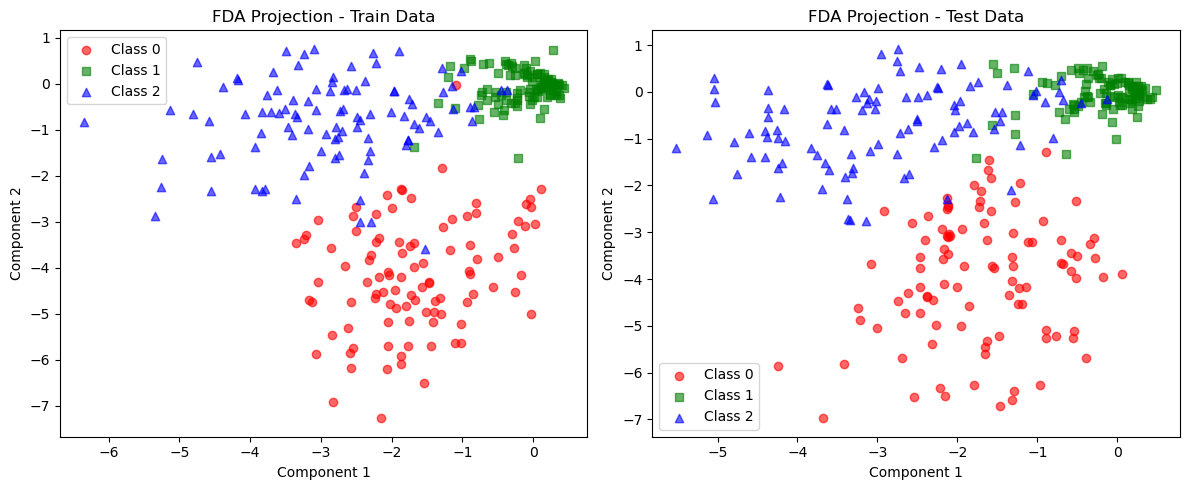

In [41]:
# FDA Visualization (Train & Test)
plot_2D_projection(
    np.dot(Wfda.T, X_train), 
    np.dot(Wfda.T, X_test),  
    y_train, y_test, 
    "FDA Projection"
)

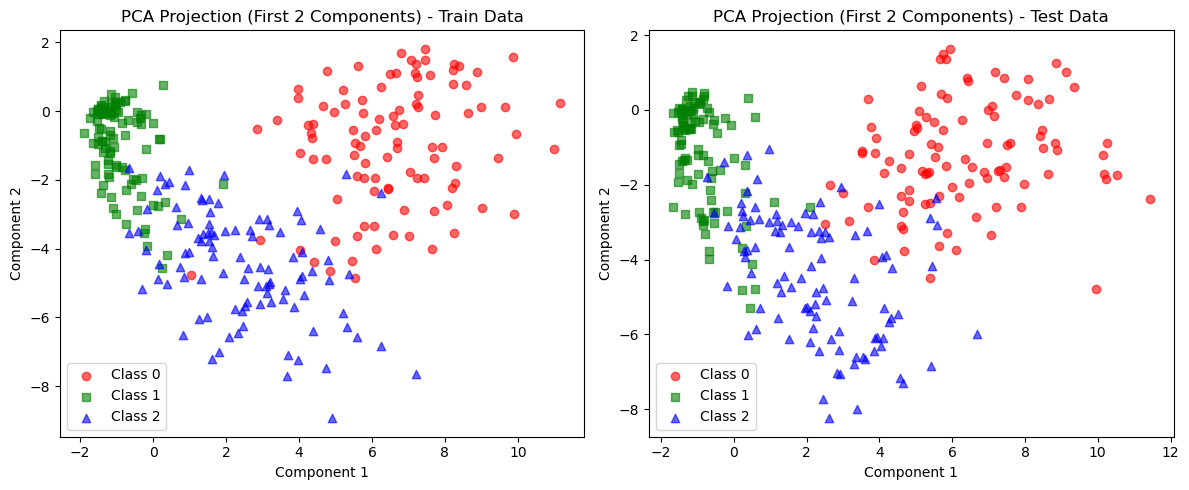

In [42]:
# PCA Visualization (First 2 Components) (Train & Test)
plot_2D_projection(
    X_train_pca_2, 
    X_test_pca_2,
    y_train, y_test, 
    "PCA Projection (First 2 Components)"
)

## Conclusion
PCA and FDA significantly improve classification performance by reducing dimensionality and maximizing class separation.